In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
data = pd.read_csv("merged_df.csv")
data.sample(10)

,id,ts,platform,ms_played,track_name,artist_name,album_name_x,reason_start,reason_end,shuffle,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
45796,0lE2q3brrqkQNApUl3Jk8b,2018-11-08 04:46:54,android,2053,Winter Winds,Mumford & Sons,Sigh No More,fwdbtn,fwdbtn,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115208,5nw6Uk1a2NkmTqfalBvMia,2022-06-08 03:38:45,android,288626,Dice la gente,Kiko Veneno,Dice la gente,trackdone,trackdone,False,...,0,-9.940,1,0.0429,0.5650,0.120000,0.1090,0.307,91.020,288627.0
145121,3F34I6GIzPjDUMSHVpo7RP,2024-12-15 23:05:19,android,280293,Get Out While You Can,James Bay,Chaos And The Calm,trackdone,trackdone,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81760,2dFjeuAs19gRJaFCDnqBiM,2020-11-17 17:49:03,android,124520,Reminder,Mumford & Sons,Babel,clickrow,trackdone,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64884,52rWZajfmiprmZklqkpXAR,2020-02-29 06:10:39,android,170840,Wanted Man,Johnny Cash,Little Fauss and Big Halsy (Original Soundtrac...,trackdone,trackdone,True,...,2,-10.796,1,0.0496,0.4140,0.000020,0.1170,0.755,91.384,170840.0
45107,18EJAVOK798yudChOBc9Lu,2018-10-17 06:05:44,android,657,Old School,Hedley,Famous Last Words,fwdbtn,fwdbtn,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30865,3pKKxkeB1pOUMHwWBmKc3Y,2017-10-25 16:25:38,android,156826,Fixing A Hole - Remastered 2009,The Beatles,Sgt. Pepper's Lonely Hearts Club Band,trackdone,trackdone,True,...,0,-8.917,0,0.0451,0.3820,0.000000,0.0783,0.619,112.984,156827.0
136640,0JBvtprXP2Z0LP3jmzA7Xp,2024-01-30 20:52:03,android,181306,"Baby, You're A Rich Man - Remastered 2009",The Beatles,Magical Mystery Tour,trackdone,trackdone,True,...,7,-9.635,1,0.0360,0.0119,0.000001,0.1520,0.467,96.751,181307.0
83163,3yAxxrbz8QtaJsmQhDgSTt,2020-12-01 02:53:49,android,23,Summer Paradise (feat. K'naan),Simple Plan,Get Your Heart On!,fwdbtn,fwdbtn,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76268,5Nm9ERjJZ5oyfXZTECKmRt,2020-09-23 18:37:27,android,4815,Stay With Me,Sam Smith,In The Lonely Hour,trackdone,fwdbtn,True,...,0,-6.444,1,0.0414,0.5880,0.000064,0.1100,0.184,84.094,172724.0


In [3]:
data.columns.to_list()

['id',
 'ts',
 'platform',
 'ms_played',
 'track_name',
 'artist_name',
 'album_name_x',
 'reason_start',
 'reason_end',
 'shuffle',
 'skipped',
 'time_window',
 'name',
 'album_name_y',
 'artists',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

In [4]:
# Define the chronological order of windows
time_order = [
    '12AM–3AM',
    '3AM–6AM',
    '6AM–9AM',
    '9AM–12PM',
    '12PM–3PM',
    '3PM–6PM',
    '6PM–9PM',
    '9PM–12AM'
]

# Create mapping dictionary: 12AM–3AM = 0, 3AM–6AM = 1, etc.
time_mapping = {label: i for i, label in enumerate(time_order)}

# Map to numeric values
data['time_window_num'] = data['time_window'].map(time_mapping)

# Confirm
print(data[['time_window', 'time_window_num']].head(10))


  time_window  time_window_num
0    12AM–3AM                0
1    12AM–3AM                0
2    12AM–3AM                0
3    12AM–3AM                0
4     3AM–6AM                1
5     3AM–6AM                1
6     3AM–6AM                1
7     3AM–6AM                1
8     3AM–6AM                1
9     3AM–6AM                1


In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- User-defined inputs ---
COLUMNS_TO_INCLUDE = [
    'ms_played', 'time_window_num', 'energy', 'speechiness',
    'acousticness', 'instrumentalness', 'tempo', 'duration_ms'
]
n_clusters = 10

# --- Load and subset ---
X = data[COLUMNS_TO_INCLUDE].copy()

# --- Drop missing values ---
X = X.dropna()
data = data.loc[X.index].copy()

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Run K-Means ---
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_scaled)

# --- Inspect results ---
print("Cluster centroids (standardized):")
print(pd.DataFrame(kmeans.cluster_centers_, columns=COLUMNS_TO_INCLUDE))
print("\nCluster counts:")
print(data['cluster'].value_counts())

# Optional: silhouette evaluation
# from sklearn.metrics import silhouette_score
# score = silhouette_score(X_scaled, data['cluster'])
# print(f"\nSilhouette Score: {score:.3f}")


Cluster centroids (standardized):
   ms_played  time_window_num    energy  speechiness  acousticness  \
0  -0.085649         0.019178  0.153072    -0.210408     -0.171845   
1   0.841503         0.877417  0.402433    -0.154393     -0.542664   
2  -0.236456        -1.004846 -1.085051    -0.209811      1.222849   
3   0.063623        -0.049818  0.239550     5.256928      0.206043   
4   0.837735        -1.012198  0.419904    -0.125870     -0.535155   
5  -0.187603         0.045169  0.478532     0.275781     -0.358686   
6  -0.970501        -0.998653  0.522337    -0.108697     -0.588471   
7   0.036182         0.879013 -1.145159    -0.204310      1.311014   
8  -0.953193         0.944899  0.444953    -0.144755     -0.507511   
9   1.402875         0.103969 -0.515193    -0.136386      0.296949   

   instrumentalness     tempo  duration_ms  
0          3.542148 -0.042397     0.018076  
1         -0.237355 -0.144373     0.047051  
2         -0.227776 -0.237723    -0.299631  
3         -0.31

In [11]:
from sklearn.metrics import silhouette_score
print(silhouette_score(X_scaled, data['cluster']))

0.1717103293388681


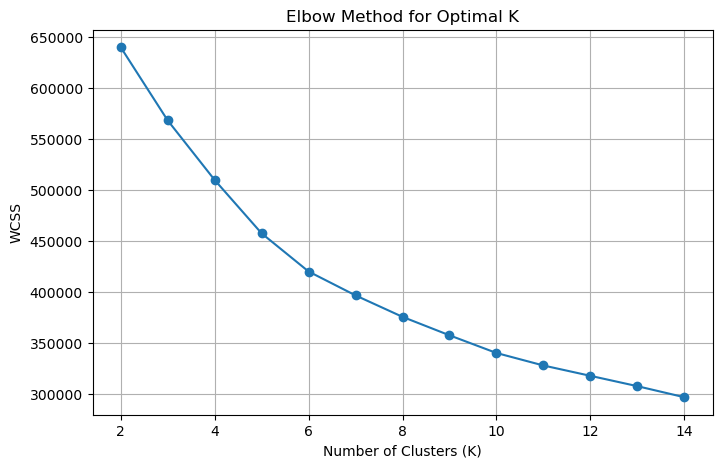

In [9]:
# Elbow Graph
import matplotlib.pyplot as plt

wcss = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

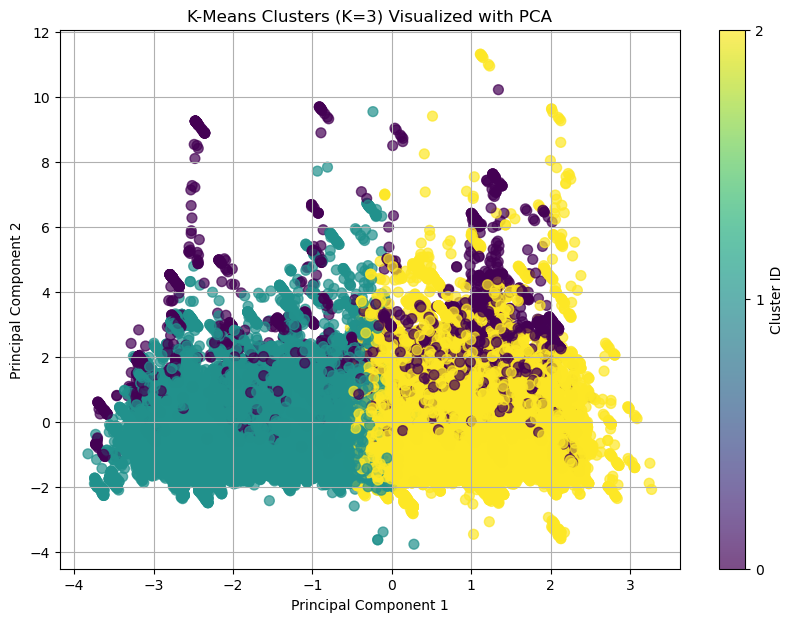

In [21]:
# Using PCA to actually plot the clusters
from sklearn.decomposition import PCA
from scipy.stats import chi2 # For confidence level calculation
import numpy as np

chosen_k = 3

# Perform K-Means with the chosen_k on the scaled data
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Perform PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.title(f'K-Means Clusters (K={chosen_k}) Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=range(chosen_k), label='Cluster ID')
plt.grid(True)

plt.show()